In [4]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers



Using TensorFlow backend.


In [8]:

path = 'input/'
comp = 'jigsaw-toxic-comment-classification-challenge/'
EMBEDDING_FILE=f'{path}glove.6B.50d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'
TEST_DATA_FILE=f'{path}test.csv'

In [9]:


# configuring basic parameters

embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use


In [10]:

# Read in our data and replace missing values:

train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values



In [11]:
# Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed)

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))




In [16]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

array([  475,    93,    59,  1541,    11,   407,     6,   151,    95,
          57,  8229,   596,     2,  1078,    76,     2,    82,   516,
          11,    44,   121,     5,   250,   110,    10,    20,   300,
           1,   520,    33,     2,    66,  1119,   546,  1000,    15,
           5,   203,   443,    86,  9660, 13832,    25,    47,     6,
          18,   491,     1,   202,    15,    70,    52,     8,     7,
          59,  1166,     6,     2,  3485,     2,   255,    26,     7,
         105,     2,    97,    11,   368,     9,     7,   391,    20,
         223,    10,    13,  5750,   862,  1067,     4,     7,    67,
          92,    19,   131,   750,     3,     1,   498,    62,    47,
         264,    21,    35,    38,  1571,  2358,   469,  2280,   566,
         182], dtype=int32)

In [17]:
# Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))




In [18]:
# Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector



In [19]:
# Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
# Now we're ready to fit out model! Use validation_split when not submitting.

model.fit(X_t, y, batch_size=32, epochs=5, validation_split=0.1);



Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 833s 6ms/step - loss: 0.0582 - acc: 0.9798 - val_loss: 0.0488 - val_acc: 0.9823
Epoch 2/2
143613/143613 [==============================] - 818s 6ms/step - loss: 0.0441 - acc: 0.9834 - val_loss: 0.0455 - val_acc: 0.9833


In [23]:
# # And finally, get predictions for the test set and prepare a submission CSV:

# y_test = model.predict([X_te], batch_size=1024, verbose=1)
# sample_submission = pd.read_csv(f'{path}sample_submission.csv')
# sample_submission[list_classes] = y_test
# sample_submission.to_csv('submission.csv', index=False)

153164/153164 [==============================] - 80s 522us/step


In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total para

In [31]:
model.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

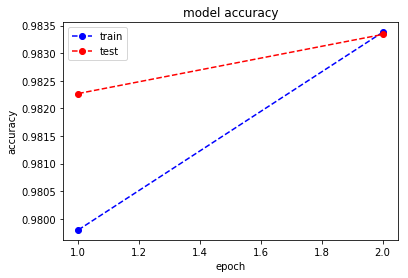

In [98]:
import matplotlib.pyplot as plt
A = range(1,len(model.history.history['acc'])+1)
B = [ round(i,5) for i in model.history.history['acc']]
C = [ round(i,5) for i in model.history.history['val_acc']]

plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# for xy in zip(A, B):                                       # <--
#     plt.annotate('TRN(%s, %s)' % xy, xy=xy, textcoords='data') # <--
# for xy in zip(A, C):                                       # <--
#     plt.annotate('TST(%s, %s)' % xy, xy=xy, textcoords='data') # <--

plt.legend(['train', 'test'], loc='upper left')
plt.show()

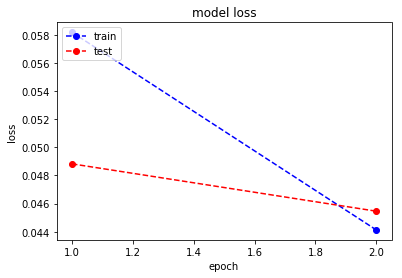

In [97]:
A = range(1,len(model.history.history['loss'])+1)
B = model.history.history['loss']
C = model.history.history['val_loss']
plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [89]:
def sample_test(S1,model):
    v=tokenizer.texts_to_sequences([S1])
    v=pad_sequences(v,maxlen=maxlen)
    y=list(model.predict([v], batch_size=1024, verbose=1))
    for i in range(6):
        print(y[0][i], list_classes[i])

In [86]:
S1 = input("Sentence: ")
sample_test(S1)

Sentence: you are a piece of shit
1/1 [==============================] - 0s 28ms/step
0.99585295 toxic
0.16751765 severe_toxic
0.95718527 obscene
0.009337059 threat
0.8679588 insult
0.008784916 identity_hate


In [85]:
S1 = input("Sentence: ")
sample_test(S1)


Sentence: this is toxic comment classifier
1/1 [==============================] - 0s 22ms/step
0.05967305 toxic
9.319942e-05 severe_toxic
0.0065695685 obscene
0.00048581205 threat
0.007874795 insult
0.0004620122 identity_hate


In [84]:
S1 = input("Sentence: ")
sample_test(S1)


Sentence: white walkers are here to kill us all
1/1 [==============================] - 0s 27ms/step
0.5513399 toxic
0.009805149 severe_toxic
0.06635562 obscene
0.15000723 threat
0.15230429 insult
0.11718587 identity_hate


In [83]:
S1 = input("Sentence: ")
sample_test(S1)


Sentence: John will rule over kings village
1/1 [==============================] - 0s 23ms/step
0.0031414186 toxic
7.4476766e-06 severe_toxic
0.00062633865 obscene
3.6269612e-05 threat
0.00027254125 insult
6.8956324e-05 identity_hate


In [81]:
S1 = input("Sentence: ")
sample_test(S1)

Sentence: i hate you
1/1 [==============================] - 0s 22ms/step
0.8523341 toxic
0.01763573 severe_toxic
0.25139645 obscene
0.03235728 threat
0.43220508 insult
0.042074043 identity_hate


In [82]:
S1 = input("Sentence: ")
sample_test(S1)

Sentence: I love you
1/1 [==============================] - 0s 21ms/step
0.10507312 toxic
0.0004556363 severe_toxic
0.013401269 obscene
0.002173311 threat
0.025306152 insult
0.0015824061 identity_hate


In [87]:
from keras.models import model_from_json
model_json = model.to_json()
with open("Bi_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Bi_model.h5")
print("Saved model to disk")

Saved model to disk


In [88]:
# load json and create model
json_file = open('Bi_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Bi_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [96]:
# evaluate loaded model on test data

S1 = input("Sentence: ")
sample_test(S1,loaded_model)

# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Sentence: I want to kill all the fun
1/1 [==============================] - 0s 32ms/step
0.54252684 toxic
0.010679934 severe_toxic
0.070886485 obscene
0.18541855 threat
0.13060147 insult
0.07082113 identity_hate
